# GPR1200 Dataset
https://github.com/Visual-Computing/GPR1200

https://visual-computing.com/files/GPR1200/GPR1200.zip

In [25]:
# Root path for all 
root_path = 'A:/IVADL'

In [26]:
import os
import json
import posixpath
import shutil

In [27]:
# Root path for GPR1200
gpr1200_path = posixpath.join(root_path, "GPR1200")

# Path to the JSON file
json_file = posixpath.join(gpr1200_path, "GPR1200_categoryNumber_to_text.json")

# Path to the folder containing the images
images_folder = posixpath.join(gpr1200_path, "images")

# Path to the folder containing the dataset
dataset_folder = posixpath.join(gpr1200_path, "dataset")

In [28]:
# Load the JSON data
with open(json_file, 'r') as file:
    data = json.load(file)

In [29]:
# Iterate over the JSON data
for key, value in data.items():
    # Create the folder if it doesn't exist
    folder_path = posixpath.join(images_folder, key)
    os.makedirs(folder_path, exist_ok=True)

    # Construct the prefix to identify relevant images
    prefix = f"{key}_"

    # Move images with the matching prefix and extensions
    for filename in os.listdir(images_folder):
        if filename.startswith(prefix) and filename.lower().endswith(('.jpg', '.jpeg')):
            source_path = posixpath.join(images_folder, filename)
            destination_path = posixpath.join(folder_path, filename)
            print(f"Moving {filename} to {destination_path}")
            shutil.move(source_path, destination_path)


In [30]:
# %pip install split-folders

In [31]:
import splitfolders

# Splitting the dataset into training, validation, and test sets with a ratio of 70%, 20%, and 10% respectively.
splitfolders.ratio(
    input=images_folder,            # Source folder containing the images
    output=dataset_folder,          # Destination folder to save the split datasets
    seed=1337,                      # Random seed for reproducibility
    ratio=(0.7, 0.2, 0.1),          # Ratio for splitting into training, validation, and test sets
    group_prefix=None,              # Group images by prefix (default is None)
    move=False                      # Copy files instead of moving (default is False)
)


Copying files: 12000 files [00:19, 600.97 files/s] 


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

In [33]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 35
DATA_DIR_PATH = dataset_folder

In [35]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    posixpath.join(dataset_folder, "train"),
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    posixpath.join(dataset_folder, "val"),
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    posixpath.join(dataset_folder, "test"),
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

Found 8400 files belonging to 1200 classes.
Found 2400 files belonging to 1200 classes.
Found 1200 files belonging to 1200 classes.


In [37]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '1110', '1111

In [38]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [39]:
# Data augmentation/preparation
train_ds = prepare(train_ds, shuffle=True, augment=True)
# train_ds = prepare(train_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

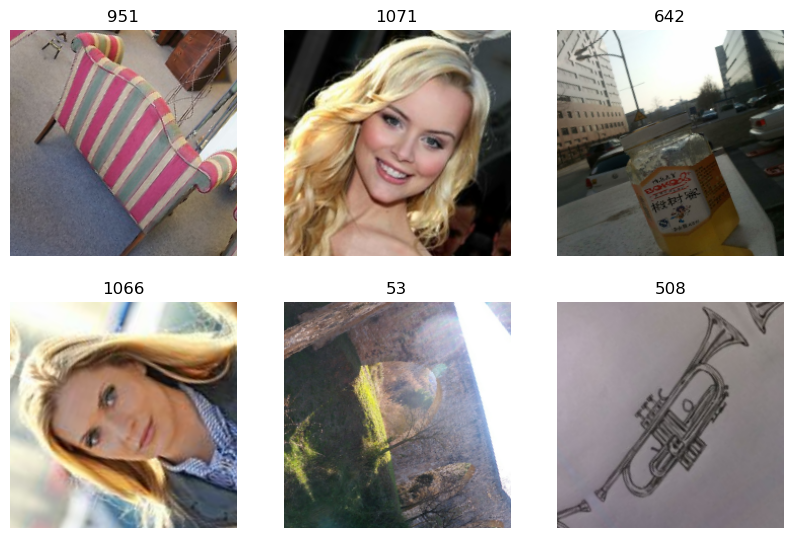

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6): # Plot 6 images from a random batch
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
CLASSES = 1200

effnet_model = Sequential()

pretrained_model= tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg',
    classes=CLASSES,
    weights='imagenet'
)

for layer in pretrained_model.layers:
        layer.trainable=False

effnet_model.add(pretrained_model)
effnet_model.add(Flatten())
effnet_model.add(Dense(CLASSES, activation='softmax'))

In [42]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1200)              1537200   
                                                                 
Total params: 7,456,512
Trainable params: 1,537,200
Non-trainable params: 5,919,312
_________________________________________________________________


In [43]:
effnet_model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [44]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.log') # To not loose the history data

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        if lr0 <= 0.001:
            return lr0
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [45]:
hist = effnet_model.fit(train_ds,
                 steps_per_epoch=len(train_ds),
                 epochs=EPOCHS,
                 validation_data=val_ds,
                 validation_steps=len(val_ds),
                 callbacks=[early_stopping_callback, lr_scheduler, csv_logger]
                 )

Epoch 1/35
263/263 [==============================] - 36s 116ms/step - loss: 5.7289 - accuracy: 0.2601 - val_loss: 3.5635 - val_accuracy: 0.4454 - lr: 0.0100
Epoch 2/35
263/263 [==============================] - 28s 106ms/step - loss: 1.4962 - accuracy: 0.6861 - val_loss: 3.2284 - val_accuracy: 0.5008 - lr: 0.0089
Epoch 3/35
263/263 [==============================] - 28s 107ms/step - loss: 0.8322 - accuracy: 0.8004 - val_loss: 3.1084 - val_accuracy: 0.5263 - lr: 0.0079
Epoch 4/35
263/263 [==============================] - 29s 109ms/step - loss: 0.5077 - accuracy: 0.8694 - val_loss: 3.0184 - val_accuracy: 0.5371 - lr: 0.0071
Epoch 5/35
263/263 [==============================] - 28s 107ms/step - loss: 0.3650 - accuracy: 0.9006 - val_loss: 2.8693 - val_accuracy: 0.5508 - lr: 0.0063
Epoch 6/35
263/263 [==============================] - 28s 107ms/step - loss: 0.2227 - accuracy: 0.9373 - val_loss: 2.8332 - val_accuracy: 0.5708 - lr: 0.0056
Epoch 7/35
263/263 [==============================] 

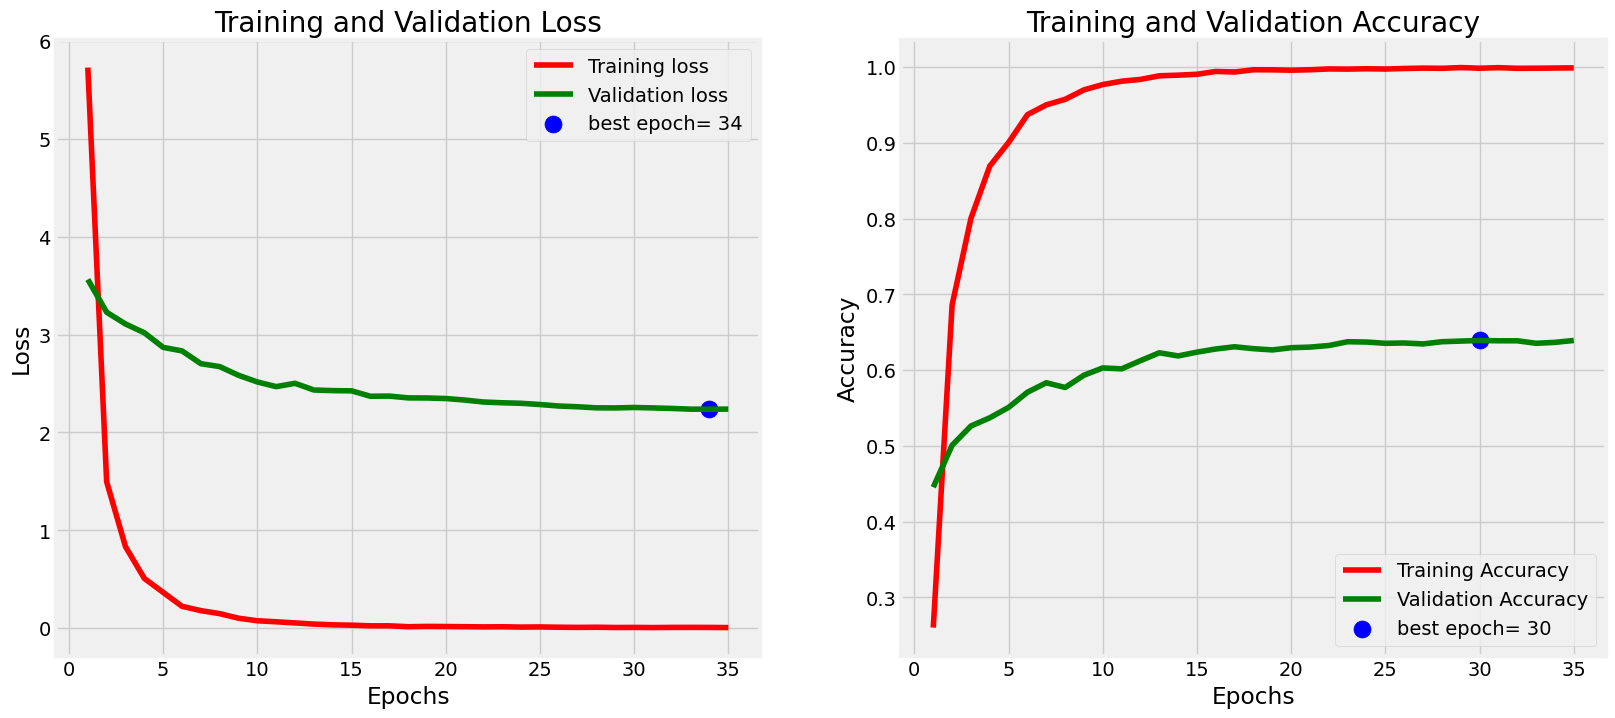

In [46]:
# Define needed variables
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [47]:
# Evaluate model on the testset
loss, ac = effnet_model.evaluate(test_ds)

38/38 [==============================] - 3s 73ms/step - loss: 2.2776 - accuracy: 0.6292


In [48]:
import json
from tensorflow.keras.models import load_model

effnet_model.save('EfficientNetB0.keras')

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

In [49]:
# %pip install opencv-python

In [53]:
import json
from tensorflow.keras.models import load_model

effnet_model = load_model('EfficientNetB0.keras')

with open('class_names.json', 'r') as f:
    class_names = json.load(f)

In [55]:
# You can ignore this cell. It was used to test on some random images I pulled off the internet. 
# If you want to try it anyways, create another folder named "tests" and put the respective images into their own folders.
import cv2
import numpy as np
import pathlib

# Path to the test images directory

# data2_dir = "tests"
data1_dir = posixpath.join(gpr1200_path, "tests")
data2_dir = pathlib.Path(data1_dir)

# List all image files in the directory
# image_files = list(data2_dir.glob("*.[jp][jpe]g"))
image_files = list(data2_dir.glob("*.[jpeg jpg png]*"))

# Check if there are images in the directory
if not image_files:
    print(f"No image files found in directory: {data2_dir}")
else:
    for image_file in image_files:
        print(f"The file name is: {str(image_file)}")

        # Display the selected image
        # PIL.Image.open(str(image_file)).show()

        # Read the selected image using OpenCV
        image = cv2.imread(str(image_file))

        # Resize the image to the required input size for the model
        image_resized = cv2.resize(image, IMG_SIZE)

        # Expand dimensions to match the input shape required by the model
        image = np.expand_dims(image_resized, axis=0)
        print(f"Image shape: {image.shape}")

        # Make a prediction using the pre-trained EfficientNet model
        pred = effnet_model.predict(image, verbose=0)

        # Determine the predicted class
        output_class = class_names[np.argmax(pred)]
        print(f"The predicted class key is: {output_class}")
        
        if output_class in data:
            print(f"The predicted class value is: {data[output_class]}")


The file name is: A:\IVADL\GPR1200\tests\banana1.jpeg
Image shape: (1, 224, 224, 3)
The predicted class key is: 594
The predicted class value is: banana
The file name is: A:\IVADL\GPR1200\tests\banana2.jpeg
Image shape: (1, 224, 224, 3)
The predicted class key is: 594
The predicted class value is: banana
The file name is: A:\IVADL\GPR1200\tests\dog.jpg
Image shape: (1, 224, 224, 3)
The predicted class key is: 845
The predicted class value is: bicycle 3
The file name is: A:\IVADL\GPR1200\tests\tiger1.jpeg
Image shape: (1, 224, 224, 3)
The predicted class key is: 451
The predicted class value is: tiger,  Panthera tigris
The file name is: A:\IVADL\GPR1200\tests\tiger2.jpeg
Image shape: (1, 224, 224, 3)
The predicted class key is: 451
The predicted class value is: tiger,  Panthera tigris
